In [65]:
import torch
import os
from importlib import import_module

In [66]:
# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
class UnNormalize():
    """정규화 되었던 이미지를 복원하는 Transforms Function.

    """
    def __init__(self, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [67]:
def load_model(saved_model, model:str, num_classes, device, **kwargs):
    model_cls = getattr(import_module("model.model"), model)
    model = model_cls(
        num_classes=num_classes,
        # 아래는 model에 추가적인 파라미터가 필요할 때 사용하시면 됩니다.
        # **kwargs
    )

    model_path = os.path.join(saved_model, 'best.pth')
    model.load_state_dict(torch.load(model_path, map_location=device))

    return model

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

def inference_model(loader, model_dir, model:str, num_classes, break_idx=300, **kwargs) -> list:
    """Confusion Matrix 출력 함수.
    Args:
        loader (dataloader)): dataloader
        model_dir (str): 저장된 모델 경로.
        num_classes (int): 클래스 갯수
        model (str): 모델 클래스명. 단, 문자열로 줘야 함.
        break_idx (int, optional): 모두 다 inference하는 것은 너무 오래 걸려서 끊어주기 위한 장치를 마련. Defaults to 300.
        **kwargs : 모델에 들어가게 되는 추가적인 파라미터들.
    Returns:
        list: 튜플 (wrong_imgs, wrong_answers, wrong_labels)을 담아낸 리스트. 이미지에 종속된 라벨을 한꺼번에 묶음.
    """
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    model = load_model(model_dir, model, num_classes, device, **kwargs).to(device)
    model.eval()

    print(f"Calculating inference results for {model_dir}..")
    
    answers = []
    preds = []
    
    # 오답 처리된 이미지들에 대해 (이미지, 정답, 오답)을 출력하기 위한 과정들.
    wrong_imgs, wrong_answers, wrong_labels = [], [], []
    with torch.no_grad():
        for idx, (images, labels) in enumerate(tqdm(loader)):
            # <계산 과정>
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1).cpu()
            
            # </계산 과정>
            indices = np.array(range(len(answers), len(answers)+len(labels)+1))
            answers.extend(labels)
            preds.extend(pred.numpy()) 
            
            # 오답 판별 과정.
            wrong_ans = (pred != labels)
            
            # 오답 판별 결과 누적.
            wrong_imgs.extend(images[wrong_ans].cpu())
            wrong_answers.extend(labels[wrong_ans].cpu())
            wrong_labels.extend(pred[wrong_ans].cpu())
            
            if idx >= break_idx:
                break

    return answers, preds, list(zip(wrong_imgs, wrong_answers, wrong_labels))
    

def display_cfmatrix(model_label, num_classes, answers, preds):
    ax = plt.subplot(1,1,1)
    
    map_label = {
        'gender':{0:'male', 1:'female'}, 
        'age':{0:'<30', 1:'>=30 and <60', 2:'>60'}, 
        'mask':{0:'mask', 1:'incorrect', 2:'normal'}
    }
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    # sklearn.metrics에서의 confusion_matrix 메서드 사용.
    cf_matrix = confusion_matrix(answers, preds, labels=list(range(num_classes)))
    sns.heatmap(cf_matrix, annot=True)
    
    # confusion_matrix의 첫 파라미터는 y축으로 두 번째 파라미터는 x축으로 감.
    ax.xaxis.set_ticklabels(map_label[model_label].values())
    ax.yaxis.set_ticklabels(map_label[model_label].values())
    plt.xlabel('pred', fontsize=14)
    plt.ylabel('answer', fontsize=14)
    

In [69]:
import matplotlib.pyplot as plt
from einops import rearrange
import random

def show(pic, label, num=20, mean_std=None):
    """Confusion Matrix 출력을 위한 공간.

    Args:
        pic (List:[tuple(wrong_imgs, wrong_answers, wrong_labels)]): inference_model의 결과값.
        num (int, optional): 출력하고 싶은 이미지 갯수. Defaults to 20.
        mean_std (tuple, optional): ((Mean), (Std))). Defaults to None.
    """
    # 출력할 때마다 다른 이미지 보여지도록 추가한 라인.
    pic = random.choices(list(pic), k=num)
    
    for idx, (img, ans, preds) in enumerate(pic):
        # 위에서 random.choices로 갯수 제한해서 필요없긴 한데 갯수 제한없이 출력했을 때,
        # 컴퓨터 터질 뻔해서 이중으로 대비했습니다.
        if idx >= num:
            break
        
        # plt.imshow는 (H, W, C)만 출력 가능해서 추가한 라인.
        img = rearrange(img, 'c h w -> h w c')
        
        # UnNormalize를 위해 추가한 코드.
        if mean_std:
            trfm = UnNormalize(*mean_std)
            img = trfm(img)
        
        map_label = {
        'gender':{0:'male', 1:'female'}, 
        'age':{0:'<30', 1:'>=30 and <60', 2:'>60'}, 
        'mask':{0:'mask', 1:'incorrect', 2:'normal'}
        }
        
        answer = map_label[label][ans.item()]
        prediction = map_label[label][preds.item()]
        
        # 이미지 출력 코드.
        plt.imshow(img)
        plt.title(f'num: {idx+1} answer: {answer}, pred: {prediction}')
        plt.axis('off')
        plt.show()

---

In [70]:
!pwd

/opt/ml/workspace/other_baseline/level1-image-classification-level1-recsys-03


In [71]:
import os
import random
from collections import defaultdict
from enum import Enum
from typing import Tuple, List

import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset, Subset, random_split, WeightedRandomSampler
# from torchvision import transforms
# from torchvision.transforms import *
from albumentations import *
from albumentations.pytorch import ToTensorV2

IMG_EXTENSIONS = [
    ".jpg", ".JPG", ".jpeg", ".JPEG", ".png",
    ".PNG", ".ppm", ".PPM", ".bmp", ".BMP",
]


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


class BaseAugmentation:
    def __init__(self, resize, mean, std, **args):
        self.transform = Compose([
            CenterCrop(320, 256, p=1.),
            Resize(resize[0], resize[1], Image.BILINEAR, p=1.),
            Normalize(mean=mean, std=std),
            ToTensorV2(p=1.),
        ], p=1.)

    def __call__(self, image):
        return self.transform(image=image)


class AddGaussianNoise(object):
    """
        transform 에 없는 기능들은 이런식으로 __init__, __call__, __repr__ 부분을
        직접 구현하여 사용할 수 있습니다.
    """

    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class CustomAugmentation:
    def __init__(self, resize, mean, std, **args):
        self.resize = resize
        self.mean = mean
        self.std = std
        self.transform =  Compose([
            CenterCrop(320, 256, p=1.),
            Resize(resize[0], resize[1], Image.BILINEAR, p=1.),
            ShiftScaleRotate(shift_limit=0.05, rotate_limit=20, p=.7),
            RandomBrightnessContrast(p=.7),
            OneOf([
                FancyPCA(p=.5),
                GaussNoise(p=.2),
            ], p=1.),
            Normalize(mean=mean, std=std),
            ToTensorV2(p=1.0),
        ], p=1.)

    def __call__(self, image):
        return self.transform(image=image)

class MaskLabels(int, Enum):
    MASK = 0
    INCORRECT = 1
    NORMAL = 2


class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:
        value = value.lower()
        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")


class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 60:
            return cls.MIDDLE
        else:
            return cls.OLD


class MaskBaseDataset(Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }
    
    image_paths = []
    
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, data_dir, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        self.data_dir = data_dir
        self.mean = mean
        self.std = std
        self.val_ratio = val_ratio # validation ratio 
        
        self.transform = None
        self.setup()
        self.calc_statistics()

    def setup(self):
        profiles = os.listdir(self.data_dir)
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.data_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)

    def calc_statistics(self):
        has_statistics = self.mean is not None and self.std is not None
        if not has_statistics:
            print("[Warning] Calculating statistics... It can take a long time depending on your CPU machine")
            sums = []
            squared = []
            for image_path in self.image_paths[:3000]:
                image = np.array(Image.open(image_path)).astype(np.int32)
                sums.append(image.mean(axis=(0, 1)))
                squared.append((image ** 2).mean(axis=(0, 1)))

            self.mean = np.mean(sums, axis=0) / 255
            self.std = (np.mean(squared, axis=0) - self.mean ** 2) ** 0.5 / 255
            print(self.mean, self.std)

    def set_transform(self, transform):
        self.transform = transform

    def __getitem__(self, index):
        assert self.transform is not None, ".set_tranform 메소드를 이용하여 transform 을 주입해주세요"

        mask_label = self.get_mask_label(index)
        gender_label = self.get_gender_label(index)
        age_label = self.get_age_label(index)
        multi_class_label = self.encode_multi_class(mask_label, gender_label, age_label)

        image = self.read_image(index)
        image_np = np.array(image)
        image_transform = self.transform(image_np)['image']
        return image_transform, multi_class_label

    def __len__(self):
        return len(self.image_paths)

    def get_mask_label(self, index) -> MaskLabels:
        return self.mask_labels[index]

    def get_gender_label(self, index) -> GenderLabels:
        return self.gender_labels[index]

    def get_age_label(self, index) -> AgeLabels:
        return self.age_labels[index]

    def read_image(self, index):
        """
        read an image from directory and return it as a numpy array
        """
        image_path = self.image_paths[index]
        return np.array(Image.open(image_path))

    @staticmethod
    def encode_multi_class(mask_label, gender_label, age_label) -> int:
        return mask_label * 6 + gender_label * 3 + age_label

    @staticmethod
    def decode_multi_class(multi_class_label) -> Tuple[MaskLabels, GenderLabels, AgeLabels]:
        mask_label = (multi_class_label // 6) % 3
        gender_label = (multi_class_label // 3) % 2
        age_label = multi_class_label % 3
        return mask_label, gender_label, age_label

    @staticmethod
    def denormalize_image(image, mean, std):
        img_cp = image.copy()
        img_cp *= std
        img_cp += mean
        img_cp *= 255.0
        img_cp = np.clip(img_cp, 0, 255).astype(np.uint8)
        return img_cp

    def split_dataset(self) -> Tuple[Subset, Subset]:
        """
        데이터셋을 train 과 val 로 나눕니다,
        pytorch 내부의 torch.utils.data.random_split 함수를 사용하여
        torch.utils.data.Subset 클래스 둘로 나눕니다.
        구현이 어렵지 않으니 구글링 혹은 IDE (e.g. pycharm) 의 navigation 기능을 통해 코드를 한 번 읽어보는 것을 추천드립니다^^
        """
        n_val = int(len(self) * self.val_ratio)
        n_train = len(self) - n_val
        train_set, val_set = random_split(self, [n_train, n_val])
        return train_set, val_set


class MaskSplitByProfileDataset(MaskBaseDataset):
    """
        train / val 나누는 기준을 이미지에 대해서 random 이 아닌
        사람(profile)을 기준으로 나눕니다.
        구현은 val_ratio 에 맞게 train / val 나누는 것을 이미지 전체가 아닌 사람(profile)에 대해서 진행하여 indexing 을 합니다
        이후 `split_dataset` 에서 index 에 맞게 Subset 으로 dataset 을 분기합니다.
    """
    # calc_statistics self.image_paths[:3000]:
    #   [0.5573112  0.52429302 0.50174594] [0.61373778 0.58633636 0.56743769]
    def __init__(self, data_dir, label='multi', mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        self.indices = defaultdict(list)
        self.label = label
        self.multi_labels = []
        self.downsample = True
        
        super().__init__(data_dir, mean, std, val_ratio)
        
        if self.label == 'multi':
            self.num_classes = 3 * 2 * 3
            self.target_label = self.multi_labels
        elif self.label == 'mask':
            self.num_classes = 3
            self.target_label = self.mask_labels
        elif self.label == 'gender':
            self.num_classes = 2
            self.target_label = self.gender_labels
        elif self.label == 'age':
            self.num_classes = 3
            self.target_label = self.age_labels
        else:
            raise ValueError(f"label must be 'multi', 'mask', 'gender', or 'age', {self.label}")
        self.class_weights = self.compute_class_weight()
    
    ### 이부분이 (__getitem__) 원래 dataset.py와 달라 부득이하게 복붙하였습니다 ###
    def __getitem__(self, index):
        img_np = self.read_image(index)
        img = self.transform(image=img_np)['image']
        return img, self.target_label[index]

    @staticmethod
    def _split_profile(profiles, val_ratio):
        length = len(profiles)
        n_val = int(length * val_ratio)

        val_indices = set(random.sample(range(length), k=n_val))
        train_indices = set(range(length)) - val_indices
        return {
            "train": train_indices,
            "val": val_indices
        }

    def setup(self):
        profiles = os.listdir(self.data_dir)
        profiles = [profile for profile in profiles if not profile.startswith(".")]
        split_profiles = self._split_profile(profiles, self.val_ratio)

        cnt = 0
        for phase, indices in split_profiles.items():
            for _idx in indices:
                include_mask = True
                profile = profiles[_idx]
                img_folder = os.path.join(self.data_dir, profile)
                lst_dir = os.listdir(img_folder)
                random.shuffle(lst_dir)  # in-place operation (add randomness in selected images with mask label)
                for file_name in lst_dir:
                    _file_name, ext = os.path.splitext(file_name)
                    if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                        continue
                    if ext != '.jpg':
                        continue
                    if self.downsample and file_name.startswith('mask'):
                        if not include_mask:
                            continue
                        include_mask = False # include only 1 mask image per profile

                    img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                    mask_label = self._file_names[_file_name]

                    id, gender, race, age = profile.split("_")
                    gender_label = GenderLabels.from_str(gender)
                    age_label = AgeLabels.from_number(age)

                    self.image_paths.append(img_path)
                    self.mask_labels.append(mask_label)
                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)
                    self.multi_labels.append(self.encode_multi_class(mask_label, gender_label, age_label))

                    self.indices[phase].append(cnt)
                    cnt += 1

    def split_dataset(self) -> List[Subset]:
        return [Subset(self, indices) for phase, indices in self.indices.items()]
    
    def get_train_labels(self, label):
        """
        returns train data of the input label
        """
        train_index = self.indices['train']
        return [label[idx] for idx in train_index]
    
    def get_classweight_label(self, label) -> torch.tensor:
        """
        returns class weight of a label within train dataset
        """
        train_labels = self.get_train_labels(label)
        _, n_samples = np.unique(train_labels, return_counts=True)
        weights = 1. / torch.tensor(n_samples, dtype=torch.float)
        return weights
    
    def normalize_weight(self, n_samples):
        norm_weights = [1 - (sample / sum(n_samples)) for sample in n_samples]
        return torch.tensor(norm_weights, dtype=torch.float)

    ##################### need refactoring ##################### 
    def get_weighted_sampler(self) -> WeightedRandomSampler:  
        """
        returns WeightedRandomSampler based on the distribution of the train label
        used to prevent overfitting due to unbalanced dataset
        """
        # # v0: weights on target label
        # train_index = self.indices['train'] # indices of train dataset
        # train_labels = [self.target_label[idx] for idx in train_index] # target_label of train dataset
        # class_counts = np.array([len(np.where(train_labels==t)[0]) for t in np.unique(train_labels)]) # get counts of each class 
        # weights = 1. / torch.tensor(class_counts, dtype=torch.float) # get weights (more class count == less weight(frequent) it will be sampled)
        # samples_weights = weights[train_labels] # map weights for each train dataset, len(samples_weights) == len(train dataset)
        # return WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)
        
        # # v1: normalized weights on target label (better than v0)
        # sample_weight = [self.class_weights[self.target_label[idx]] for idx in self.indices['train']]
        # return WeightedRandomSampler(weights=sample_weight, num_samples=len(sample_weight), replacement=True)
        
        # # v2: normalized weights on of specific ratio ``age=.9 : gender=.1``
        # age_weight = self.get_classweight_label(self.age_labels)
        # gender_weight = self.get_classweight_label(self.gender_labels)
        # weights = [age_weight[self.age_labels[idx]]*.9 + gender_weight[self.gender_labels[idx]]*.1 for idx in self.indices['train']]
        # return WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)

        # v3: normalized weights on multi label
        multi_weight = self.get_classweight_label(self.multi_labels)
        multi_weight = self.normalize_weight(multi_weight)
        sample_weight = [multi_weight[self.multi_labels[idx]] for idx in self.indices['train']]
        return WeightedRandomSampler(weights=sample_weight, num_samples=len(sample_weight), replacement=True)

    def compute_class_weight(self) -> torch.tensor:
        """
        estimate class weights for unbalanced dataset
        `` 1 - n_sample / sum(n_samples) ````
        used for loss function: weighted_cross_entropy
        """
        train_index = self.indices['train']
        train_labels = [self.target_label[idx] for idx in train_index]
        _, n_samples = np.unique(train_labels, return_counts=True)
        norm_weights = [1 - (sample / sum(n_samples)) for sample in n_samples]
        return torch.tensor(norm_weights, dtype=torch.float).to(device='cuda')

In [72]:
# from dataset import MaskSplitByProfileDataset, BaseAugmentation
from PIL import Image
import multiprocessing
from torch.utils.data import DataLoader

def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def get_dataloader(label: str='multi'):
    seed_everything(42)

    # -- settings
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # -- dataset
    data_dir = '/opt/ml/input/data/train/images'
    dataset = MaskSplitByProfileDataset(
        data_dir=data_dir,
        label=label,
    )
    
    # -- augmentation
    resize = (224, 224)
    transform = BaseAugmentation(
        resize=resize,
        mean=dataset.mean,
        std=dataset.std,
    )
    dataset.set_transform(transform)

    # -- data_loader
    dataloader = DataLoader(
        dataset,
        # batch_size=64, #args.batch_size,
        num_workers=multiprocessing.cpu_count()//2,
        shuffle=True,
        pin_memory=use_cuda,
        drop_last=True,
        # sampler=sampler,
    )
    
    # resize = [224, 224]
    # batch_size = 1000

    # data_dir = '/opt/ml/input/data/train/images'
    # dataset = MaskSplitByProfileDataset(data_dir, label, resize)
    # transform = BaseAugmentation(resize, dataset.mean, dataset.std)
    # dataset.set_transform(transform)
    # dataloader = torch.utils.data.DataLoader(
    #         dataset,
    #         # batch_size=batch_size,
    #         # num_workers=8,
    #         shuffle=False,
    #         pin_memory=torch.cuda.is_available(),
    #         drop_last=False,
    #     )
    return dataloader

In [73]:
from train import parse_model_param

class ModelEvaluator:
    def __init__(self, script: str, inference: bool=False):
        self.script = script
        self.model_param = self.parse_script()
        self.num_classes_label = {
            'multi': 18,
            'age': 3,
            'gender': 2,
            'mask': 3
        }
        self.dataloader = None
        if inference:
            self.inference
        

    def parse_script(self, script: str=None):
        """
        takes as input a script to generate a model
        returns a prediction made using the model
        """
        # i.e. python train.py --epochs 120 --dataset MaskSplitByProfileDataset --augmentation CustomAugmentation --model PretrainedModels --model_param resnet false --optimizer SGD --name ResNet_Ep120_SplitProf_Downsample_CustAugv1_WeightedCEnSamplev2_SGD_MASK --label mask
        if script is None:
            script = self.script
        
        model_param = {}
        lst_param = script.split(sep=' ')
        # default params
        model_param['label'] = 'multi'
        for idx, param in enumerate(lst_param):
            if param == '--model':
                model_param['model'] = lst_param[idx+1]
            if param == '--label':
                model_param['label'] = lst_param[idx+1]
            if param == '--name':
                model_param['name'] = lst_param[idx+1]
            if param == '--model_param':
                model_param['model_param'] = lst_param[idx+1]
        model_param['model_dir'] = os.path.join('./model', model_param['label'], model_param['name'])
        # print(model_param)
        return model_param

    def get_dataloader(self):
        self.dataloader = get_dataloader(self.model_param['label'])

    def inference(self, n_samples: int=5000, model_param: dict=None):
        if model_param is None:
            model_param = self.model_param

        model_dir = self.model_param['model_dir']
        label = self.model_param['label']
        model = self.model_param['model']
        
        self.model_param['num_classes'] = self.num_classes_label[label]
        params = parse_model_param(self.model_param['model_param'], pretrained=True)

        if self.dataloader is None:
            self.get_dataloader()
        self.ans, self.preds, self.wrong = inference_model(self.dataloader, model_dir, model, self.num_classes_label[label], 10000, **params)

    def display_cfmatrix(self):
        display_cfmatrix(
            self.model_param['label'], 
            self.model_param['num_classes'], 
            self.ans,
            self.preds
        )
    
    def display_incorrect(self, n_display: int=10):
        show(self.wrong, self.model_param['label'], n_display)

In [74]:
torch.cuda.is_available()

True

%cd bc-ai-recsys3-lv1-imgclassification

In [75]:
script_age      = 'python train.py --epochs 60 --model ResNet50 --model_param false --optimizer SGD --name ResNet50_Ep60_CustomAug_annealing --augmentation CustomAugmentation --label age --weight_version 3    --k_folds 5 '
script_gender   = 'python train.py --epochs 60 --model ResNet50 --model_param false --optimizer SGD --name ResNet50_Ep60_CustomAug2 --augmentation CustomAugmentation --label gender --weight_version 3  --k_folds 5 '
script_mask     = 'python train.py --epochs 60 --model VGGFace --model_param false --optimizer SGD --name VGGFace_Ep60_Weightv0_CustomAug --augmentation CustomAugmentation --label mask --weight_version 0'

In [76]:
# script_age = 'python train.py --epochs 60 --dataset MaskSplitByProfileDataset --augmentation CustomAugmentation --model VGGFace --model_param false --optimizer SGD --name VGGFace_Ep60_Weightv3_AGE --label age'
# script_age = 'python train.py --epochs 60 --model VGGFace --model_param false --optimizer SGD --name VGGFace_Ep60_Weightv0_CustomAug_without_oneof --augmentation CustomAug_without_oneof --label age --weight_version 0 '
age_eval = ModelEvaluator(script_age)

  0%|          | 0/7733 [00:00<?, ?it/s]

Calculating inference results for ./model/age/ResNet50_Ep60_CustomAug_annealing..


100%|██████████| 7733/7733 [02:04<00:00, 62.07it/s] 


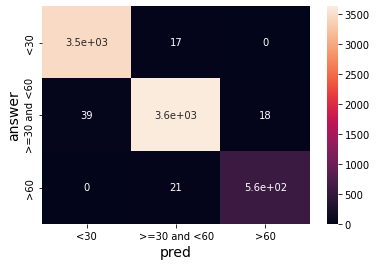

In [77]:
age_eval.inference()
age_eval.display_cfmatrix()

age_eval.inference()
age_eval.display_cfmatrix()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


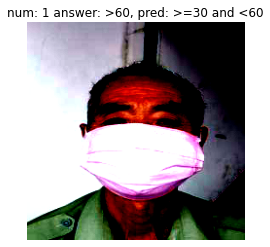

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


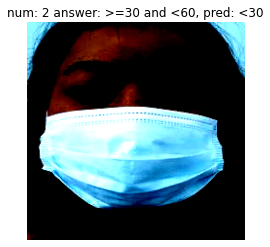

In [78]:
age_eval.display_incorrect(2)

In [79]:
# script_gender = 'python train.py --epochs 60 --model VGGFace --model_param false --optimizer SGD --name VGGFace_Ep60_Weightv0_CustomAug_without_oneof --augmentation CustomAug_without_oneof --label gender --weight_version 0 '
gender_eval = ModelEvaluator(script_gender)

In [80]:
gender_eval.inference()
gender_eval.display_cfmatrix()

  0%|          | 0/15466 [00:00<?, ?it/s]

Calculating inference results for ./model/gender/ResNet50_Ep60_CustomAug2..


 18%|█▊        | 2805/15466 [00:46<03:31, 59.84it/s] 


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


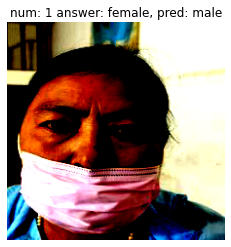

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


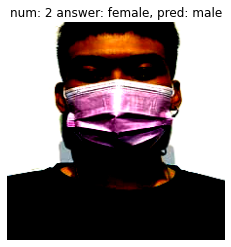

In [ ]:
gender_eval.display_incorrect(2)

In [ ]:
# script_mask = 'python train.py --epochs 60 --model VGGFace --model_param false --optimizer SGD --name VGGFace_Ep60_Weightv0_CustomAug_without_oneof --augmentation CustomAug_without_oneof --label mask --weight_version 0'
mask_eval = ModelEvaluator(script_mask)

  0%|          | 0/23199 [00:00<?, ?it/s]

Calculating inference results for ./model/mask/VGGFace_Ep60_Weightv0_CustomAug..


 43%|████▎     | 10000/23199 [01:09<01:31, 143.49it/s]


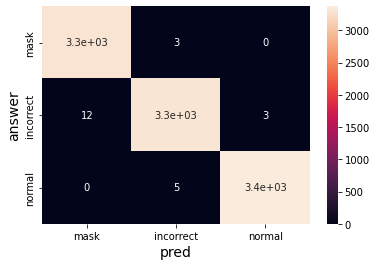

In [ ]:
mask_eval.inference()
mask_eval.display_cfmatrix()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


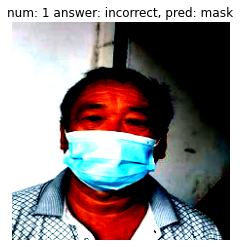

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


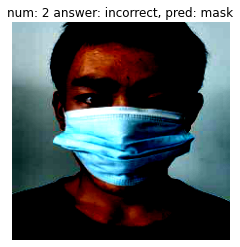

In [ ]:
mask_eval.display_incorrect(2)

In [81]:
print(f'Total: {len(age_eval.ans)}, Wrong: {len(age_eval.wrong)}')
print(f'Accuracy: {1-len(age_eval.wrong)/len(age_eval.ans)}')

Total: 7733, Wrong: 95
Accuracy: 0.9877149877149877


In [ ]:
print(f'Total: {len(gender_eval.ans)}, Wrong: {len(gender_eval.wrong)}')
print(f'Accuracy: {1-len(gender_eval.wrong)/len(gender_eval.ans)}')

Total: 10001, Wrong: 117
Accuracy: 0.9883011698830118


In [ ]:
print(f'Total: {len(mask_eval.ans)}, Wrong: {len(mask_eval.wrong)}')
print(f'Accuracy: {1-len(mask_eval.wrong)/len(mask_eval.ans)}')

Total: 10001, Wrong: 23
Accuracy: 0.9977002299770023
